# Forecasting the daily number of orders in Berlin 
### TL;DR 
To efficiently allocate supply to demand, we generate a 2 weeks ahead order forecast. 

Using a prophet model that takes temperature and media spend as extra regressors, we get an out-of-sample root mean square error of 6.7 orders, with 66.4% of observed values within the prediction interval. This is a 26% improvement on the baseline model. 

Since temperature values are only available for past days in production, not future days, we use them to explain the observed variance in the training set, but we set a predicted temperature in the prediction dataset (the median of the last week in the training set).

### Why are we forecasting the daily number of orders in Berlin?
On-time delivery is primarily driven by how many couriers are available to handle the number of orders.
Similarly, excellent customer support means low response times. Hence, we want to schedule sufficient staff answering customer requests.
Ultimately, both are caused by the number of orders. We want to inform couriers if we’re expecting higher demand and simultaneously, we schedule sufficient support agents.
When the provided demand forecast isn’t accurate both over-supplying and under-supplying can have costly consequences, e.g.:
- We might staff too many support agents
- Or we staff too few support agents and lose valuable customers through bad customer
experience.

### What does this notebook contain?
I broke this notebook down into several sections to make it easier to follow:

1. Inspecting the dataset
2. Exploring the dataset: univariate and bivariate distributions
3. Backtesting the models: baseline, exponential smoothing and Prophet models
4. Designing and deploying the model: model architecture and how I would deploy it

### How do we forecast the number of orders?
We create 14-days ahead forecasts, starting on each Monday in the dataset. Our models return the point prediction and the 95% prediction interval.
We evaluate model out-of-sample performance using forward chained validation (or backtesting), with 4 evaluation metrics: mean absolute error, root mean squared error, bias and coverage

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 

import numpy as np

from datetime import datetime, date, timedelta

from scipy.stats import norm

from typing import List, Tuple

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.signal import medfilt

from darts.models import NaiveSeasonal
from darts import TimeSeries

from prophet import Prophet
from prophet.utilities import regressor_coefficients

from sklearn.metrics import mean_squared_error, mean_absolute_error

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


# Data pulling

In [2]:
data = pd.read_csv('../data/data.csv')
data = (
    data
    .assign(
        date=pd.to_datetime(data.date).dt.date, 
        datetime=pd.to_datetime(data.date)
    )
    .rename(
        mapper={'orders':'raw_orders'}, 
        axis=1
    )
)
data.set_index('datetime', inplace=True)

# 1. Inspecting the dataset

In [3]:
data.head()

,date,raw_orders,temperature,media_spend
datetime,,,,
2020-05-02,2020-05-02,54,18.270322,0.0
2020-05-03,2020-05-03,63,19.882444,0.0
2020-05-04,2020-05-04,56,16.878095,0.0
2020-05-05,2020-05-05,65,21.878648,0.0
2020-05-06,2020-05-06,64,21.112398,0.0


## EDA: summary statistics

In [4]:
str(data.index.min().date()), str(data.index.max().date())

('2020-05-02', '2022-06-30')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790 entries, 2020-05-02 to 2022-06-30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         790 non-null    object 
 1   raw_orders   790 non-null    int64  
 2   temperature  769 non-null    float64
 3   media_spend  790 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 30.9+ KB


## Comments
The dataset contains some null values in the `temperature` column. We deal with these missing values below, when using temperature as a covariate while predicting orders.

# 2. Exploring the dataset
## 2.1 Univariate distribution: orders

In [6]:
data.raw_orders.describe()

count     790.000000
mean       89.056962
std       200.765633
min        40.000000
25%        67.250000
50%        78.000000
75%        86.000000
max      4080.000000
Name: raw_orders, dtype: float64

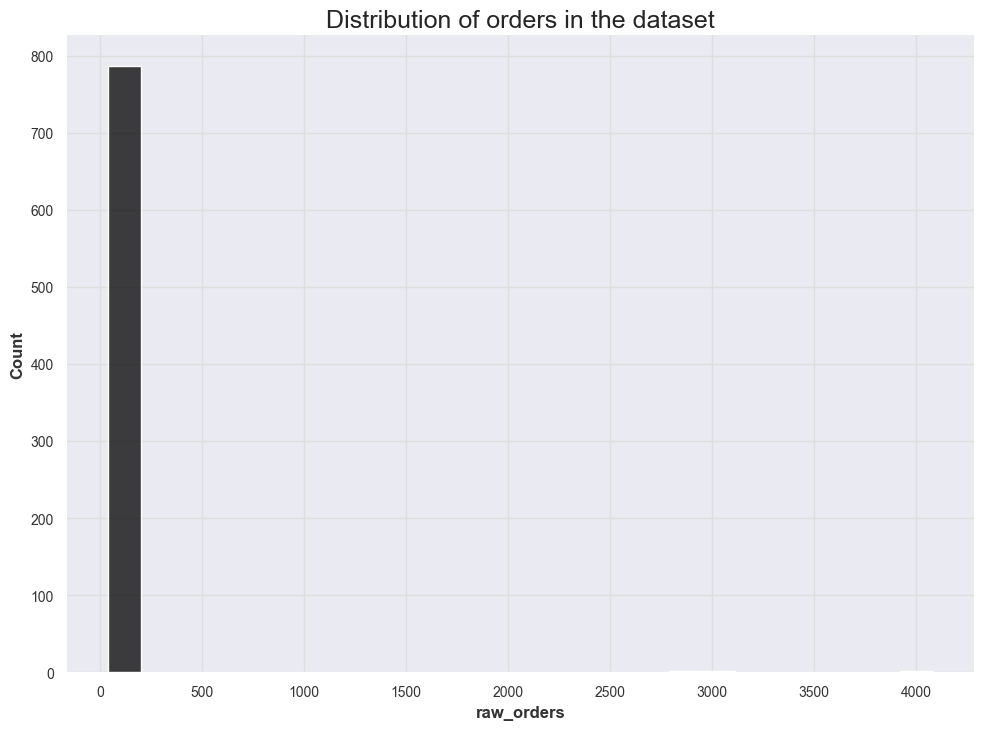

In [7]:
sns.histplot(data.raw_orders, bins=25);
plt.title('Distribution of orders in the dataset', fontsize=18);

In [8]:
data.nlargest(n=5, columns='raw_orders')

,date,raw_orders,temperature,media_spend
datetime,,,,
2021-03-22,2021-03-22,4080,20.155265,0.000000
2020-06-03,2020-06-03,2952,9.493584,0.000000
2021-01-14,2021-01-14,2816,-4.468595,0.000000
2021-08-29,2021-08-29,113,26.740306,14.650641
2021-10-27,2021-10-27,111,29.556762,14.891258


### Comments
It looks like there are 3 extreme outlier data points. It is highly unlikely that these are actually observed as they are at least 30 times larger than the average daily number of orders. They could be caused by telemetry problems, or double-counting in an upstream pipeline.

### Preprocessing: Removing outliers
During the exploration stage, we use a simple mean filter to remove the observed outliers. We then use linear interpolation. This changes 3 values in the dataset. We use the interpolated values in the rest of the exploration stage. In the rest of the notebook, we will use a different strategy to deal with outliers, that would work in a production setting, in order to train and evaluate the forecasting models. 

In [9]:
def _mean_filter(ts: pd.Series, window=14, std=3):
    """
    A simple mean filter, removes (i.e. replace by np.nan) observations that exceed (default = 3) 
    standard deviation from the mean over window of length (default = 14) centered around each observation.
    """
    
    return np.where(
        (ts<ts.rolling(window=window, center=False).mean() - std*ts.rolling(window=window, center=False).std())|(ts>ts.rolling(window=window, center=False).mean() + std*ts.rolling(window=window, center=False).std()), 
        np.nan, 
        ts
    )

In [10]:
def remove_outliers(df: pd.DataFrame):
    df = df.assign(orders=_mean_filter(df.raw_orders))
    df = df.assign(orders=df.orders.interpolate().round())
    return df

In [11]:
data = remove_outliers(data)

#### Snapshot: samples affected by mean filter

In [12]:
data.loc[data.orders != data.raw_orders]

,date,raw_orders,temperature,media_spend,orders
datetime,,,,,
2020-06-03,2020-06-03,2952,9.493584,0.0,62.0
2021-01-14,2021-01-14,2816,-4.468595,0.0,54.0
2021-03-22,2021-03-22,4080,20.155265,0.0,76.0


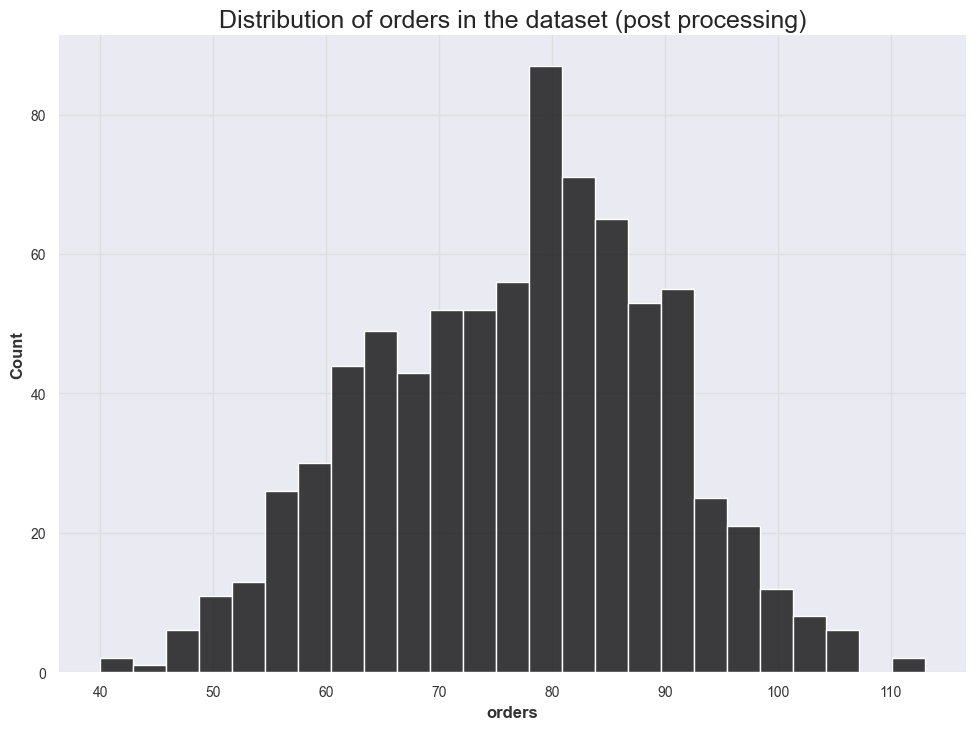

In [13]:
sns.histplot(data.orders, bins=25);
plt.title('Distribution of orders in the dataset (post processing)', fontsize=18);

### Comments
The number of orders seems to be following a normal distribution, with a mean around ~80 orders. All samples have between 40 and 120 orders.

## 2.2 Univariate distribution: temperature

In [14]:
data.temperature.isnull().sum()

21

In [15]:
data.temperature.describe()

count    769.000000
mean      17.356958
std        9.881137
min       -9.979354
25%       11.003947
50%       18.294586
75%       24.021989
max       37.945260
Name: temperature, dtype: float64

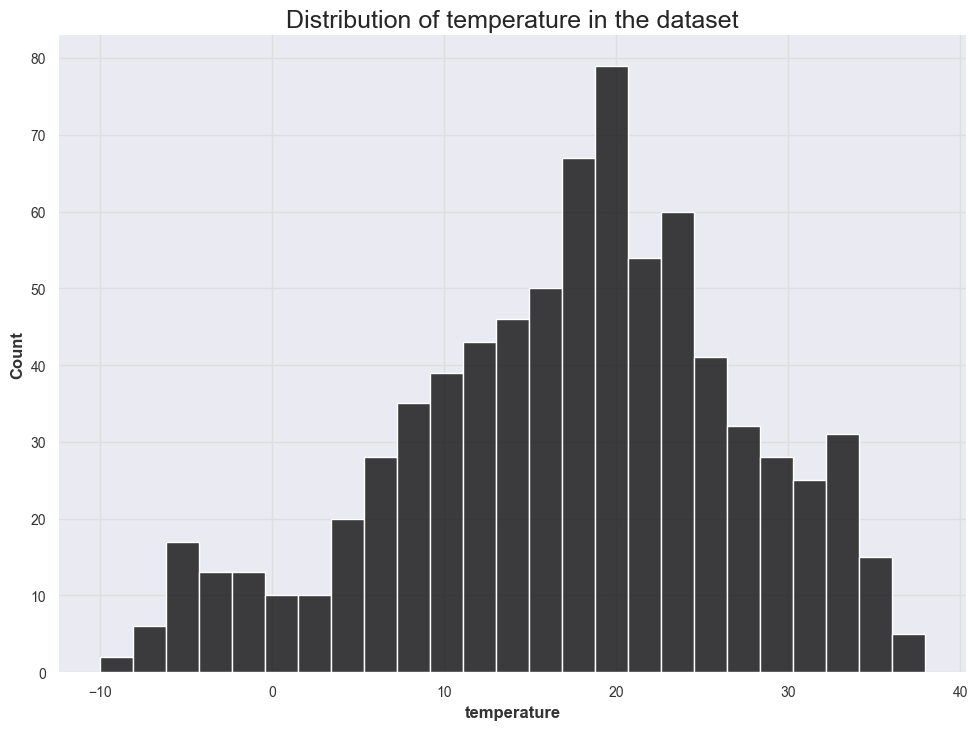

In [16]:
sns.histplot(data.temperature, bins=25);
plt.title('Distribution of temperature in the dataset', fontsize=18);

### Comments
Temperatures follow a normal distribbution with a left skew. Temperatures are between -10 and 40 degrees, which is representative of Berlin weather. We impute missing temperatures in section #3 of the notebook.

## 2.3 Univariate distribution: marketing spend

In [17]:
data.media_spend.describe()

count    790.000000
mean       0.502559
std        2.673492
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       14.990670
Name: media_spend, dtype: float64

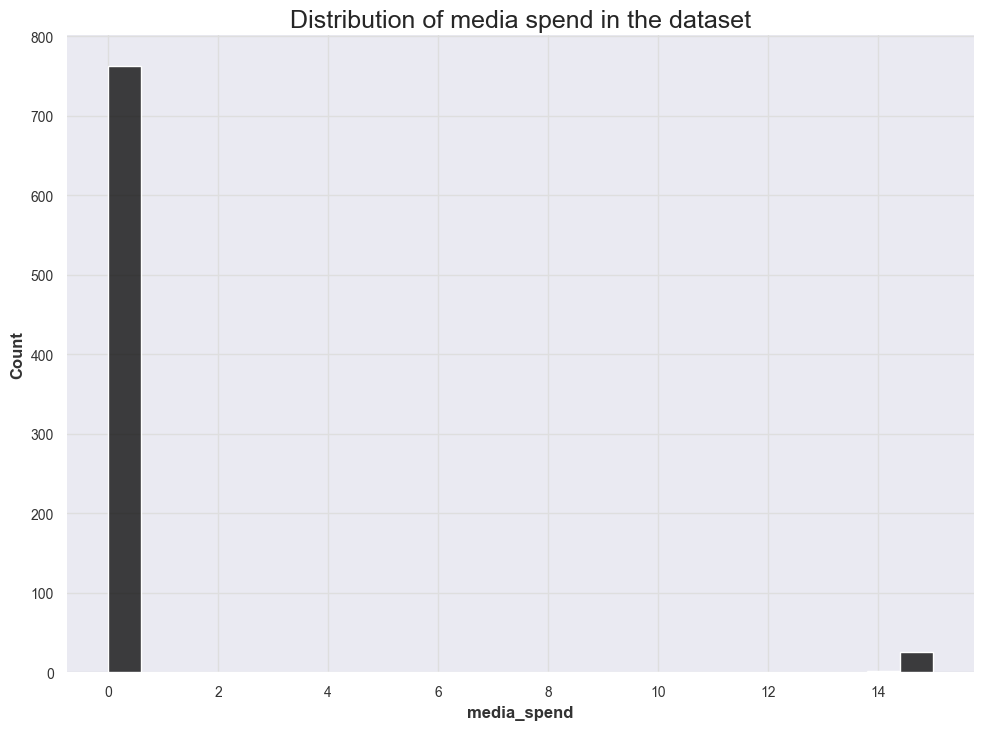

In [18]:
sns.histplot(data.media_spend, bins=25);
plt.title('Distribution of media spend in the dataset', fontsize=18);

### Comments
The majority of samples have no marketing spend. All those that do have a very similar amount of marketing spend, around ~14 currency units.

## 2.4 Bivariate distribution: date --> orders

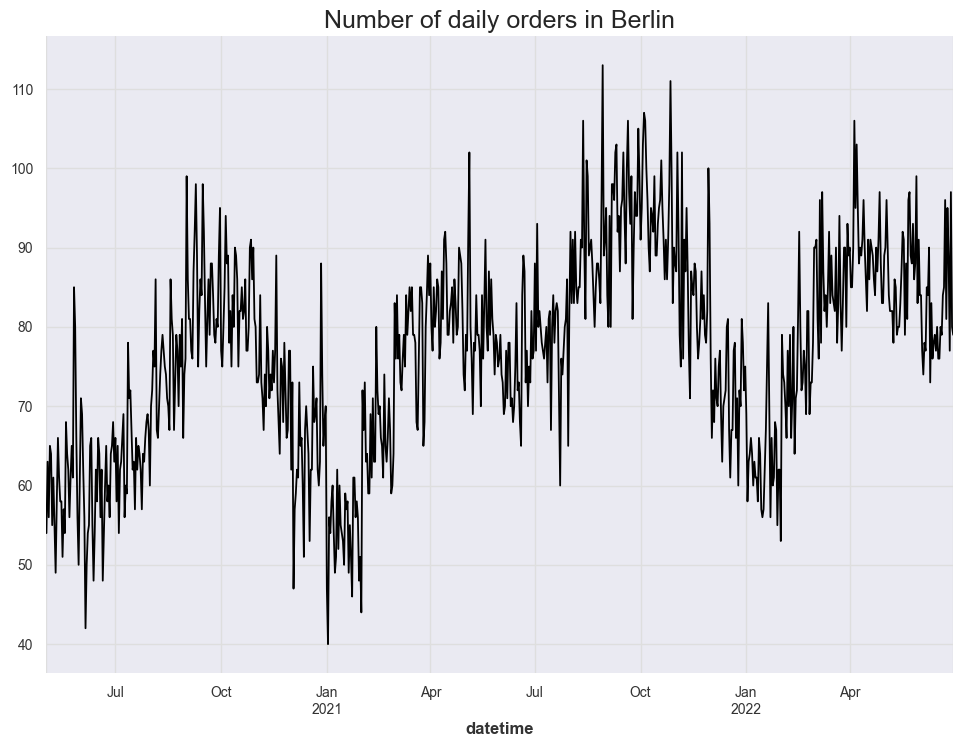

In [19]:
data.orders.plot();
plt.title('Number of daily orders in Berlin', fontsize=18);

### Additive decomposition of the `orders` time series

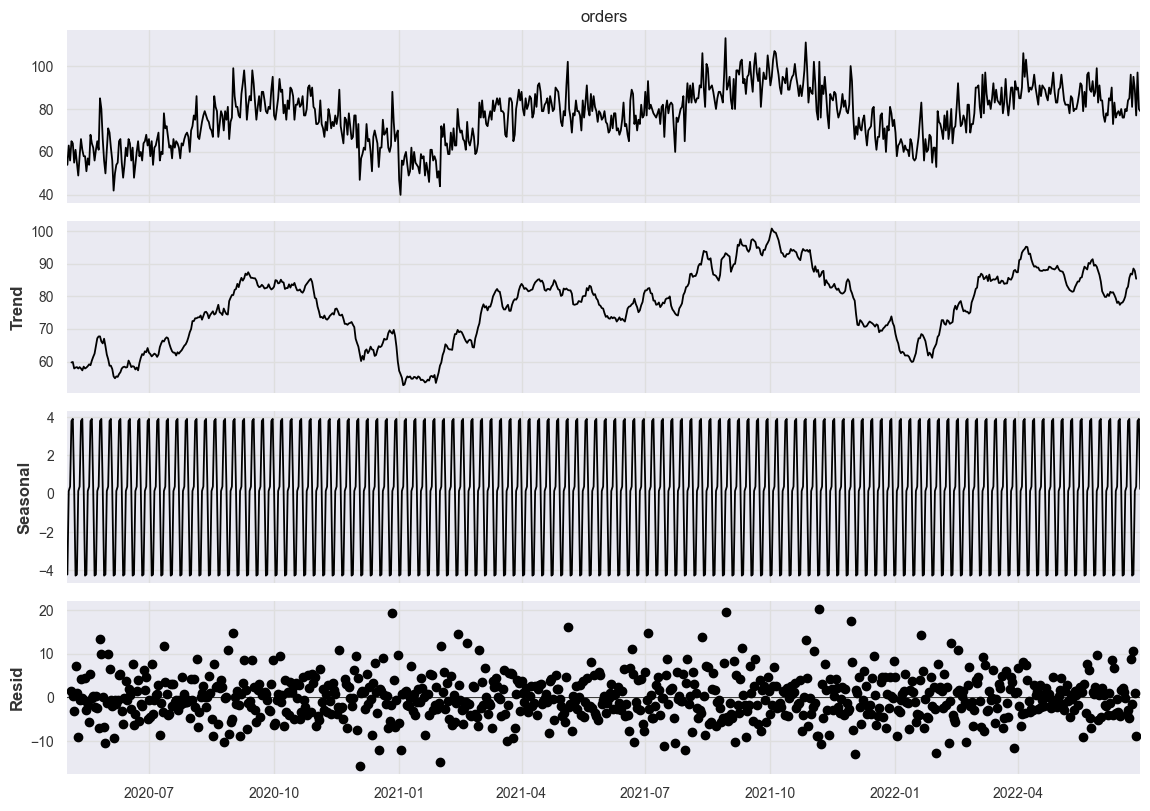

In [20]:
decomp = seasonal_decompose(data.orders, model='additive')
decomp.plot();

### Comments
By decomposing the time series into its additive components, we can observe a weekly seasonality, as well as a cyclical trend, which is slightly positive. This indicates a yearly seasonality as well, with yearly peaks coming around April, and troughs in January. In addition to this, residuals seem to contain information, which could indicate that other covariates could explain the number of orders observed on a given day.

Below, we drill down on the weekly seasonality, by visualising orders as a function of the day of the week.

## 2.5 Bivariate distribution: day of week --> orders

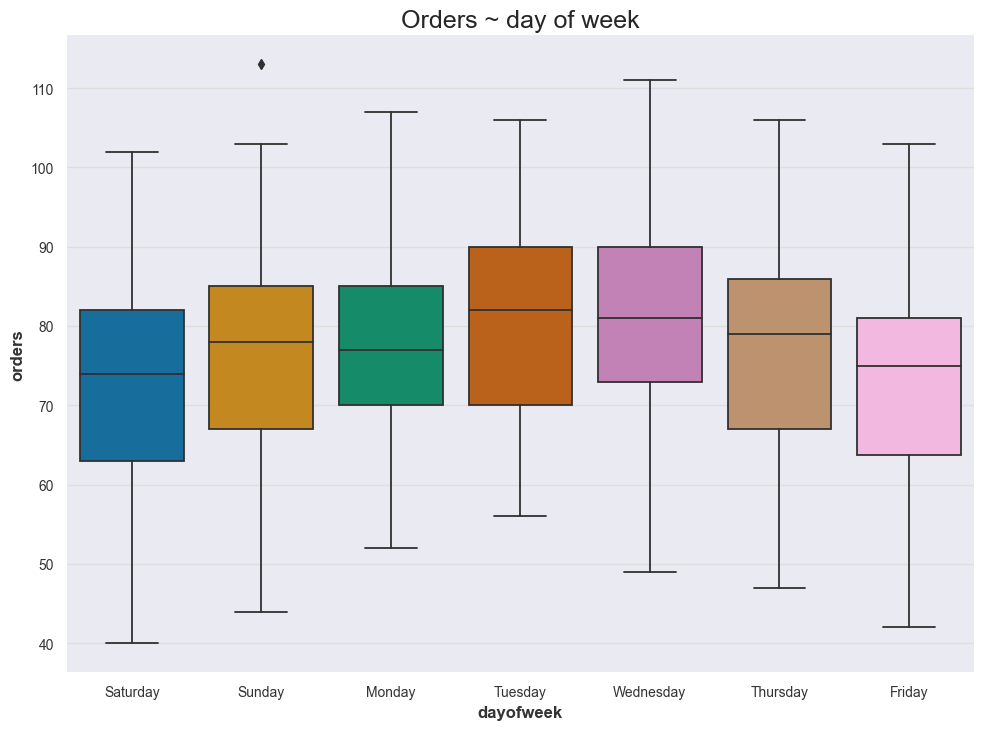

In [21]:
data = data.assign(dayofweek= data.index.day_name())
sns.boxplot(x='dayofweek', y='orders', data=data, palette='colorblind')
plt.title('Orders ~ day of week', fontsize=18);

### Comments
Demand peaks on Tuesdays and Wednesdays, and dips on Fridays and Saturdays.

## 2.6 Bivariate distribution: temperature --> orders

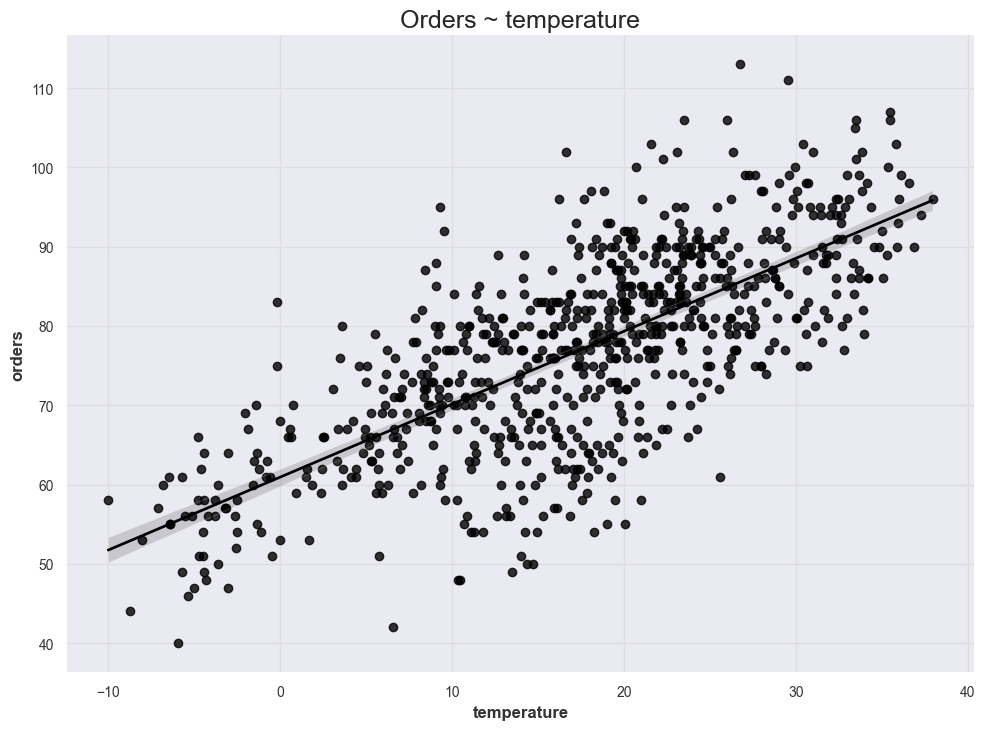

In [22]:
sns.regplot(x='temperature', y='orders', data=data);
plt.title('Orders ~ temperature', fontsize=18);

### Comments
There seems to be a positive linear relationship between temperature and the order volume.

## 2.7 Bivariate distribution: month of year --> temperature
Having eyeballed a couple of samples, I saw that the temperature looked off more than once. This bivariate plot is a sanity check.

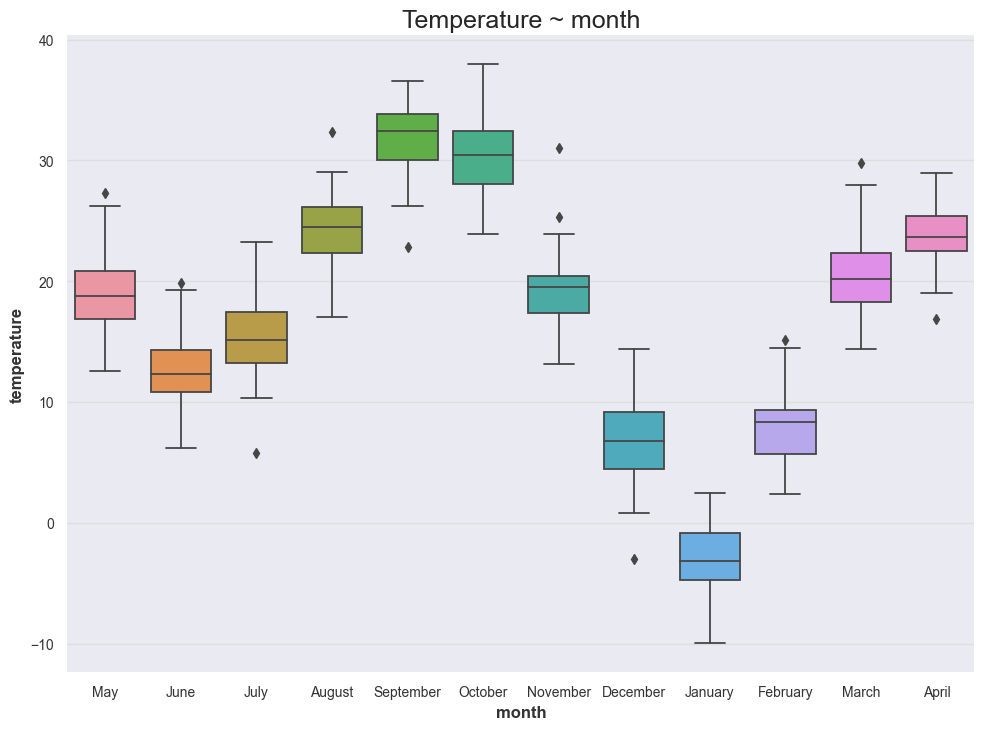

In [23]:
data = data.assign(month = data.index.month_name())
sns.boxplot(x='month', y='temperature', data=data);
plt.title('Temperature ~ month', fontsize=18);

### Comments
The temperature pattern looks off, with a median temperature of ~12 degrees in June in Berlin, and peaks above 30 degrees in September/October. 

In addition, we can observe some temperature "outliers": data points for which the temperature is below/above the expected range given the time of the year. We create a dedicated feature to capture this information.

### Feature engineering: temperature range
Samples are considered "cold" if they are 2 standard deviations below the median temperature of their 14 day window, "hot" if they are 2 standard deviations above.

In [24]:
def _temperature_filter(ts: pd.Series, window=14, std=2):
    """
    A simple median filter, encodes observations that exceed (respectively fall below) N (default = 2) 
    standard deviation from the median over window of length P (default = 14) centered around each observation as hot (respectively cold).
    """
    
    return np.where(
        ts<ts.rolling(window).median() - std*ts.rolling(window).std(),
        'cold',
        np.where(
            ts>ts.rolling(window).median() + std*ts.rolling(window).std(),
            'hot',
            'normal'
        )
    )

In [25]:
data = data.assign(temperature_range= _temperature_filter(ts=data.temperature))

#### Snapshot: number of samples per temperature_range value

In [26]:
data[['date', 'temperature_range']].groupby('temperature_range').count()

,date
temperature_range,
cold,20
hot,24
normal,746


## 2.8 Bivariate distribution: temperature range --> orders

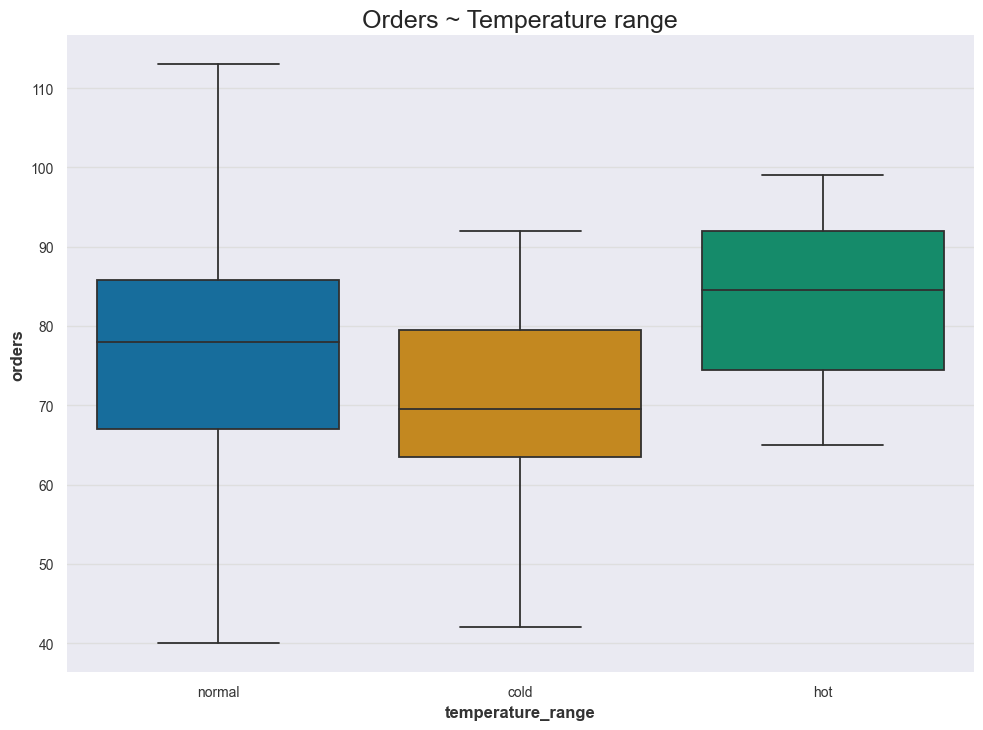

In [27]:
sns.boxplot(x='temperature_range', y='orders', data=data, palette='colorblind');
plt.title('Orders ~ Temperature range', fontsize=18);

### Comments
Samples with temperature above the expected temperature for that time of the year seem to see more demand, while those below the expected temperature see less demand.

## 2.9 Bivariate distribution: marketing spend --> orders

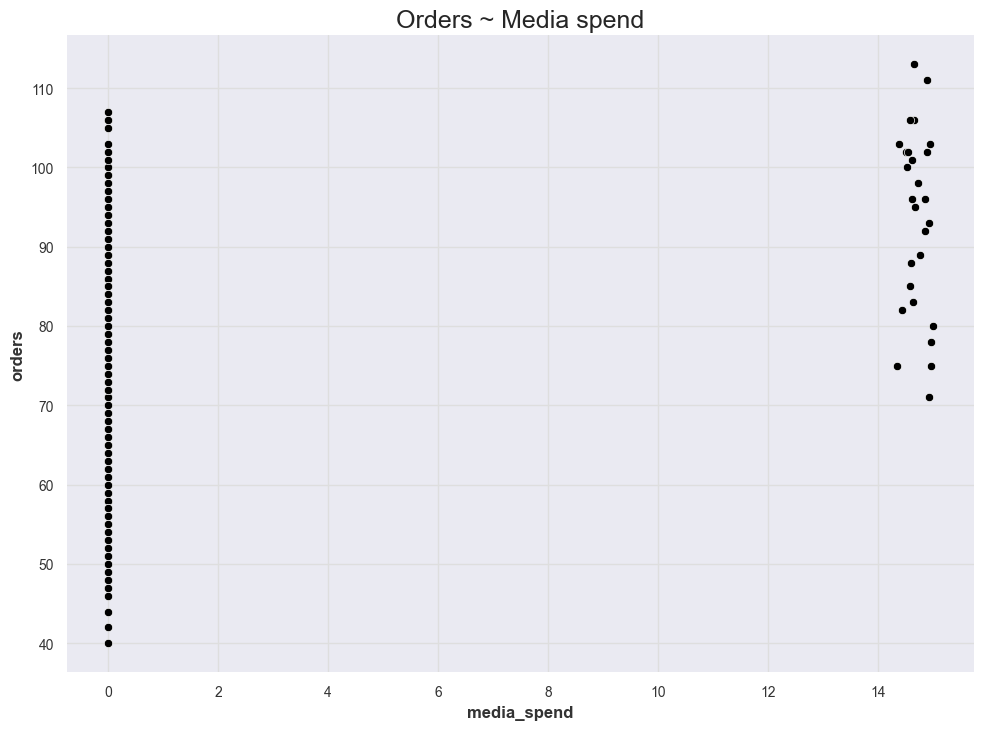

In [28]:
sns.scatterplot(x='media_spend', y='orders', data=data);
plt.title('Orders ~ Media spend', fontsize=18);

### Comments
Because most samples with a non zero marketing spend have very similar marketing spend, we binarize this feature: 0 (no marketing spend), 1 ( >0 marketing spend)

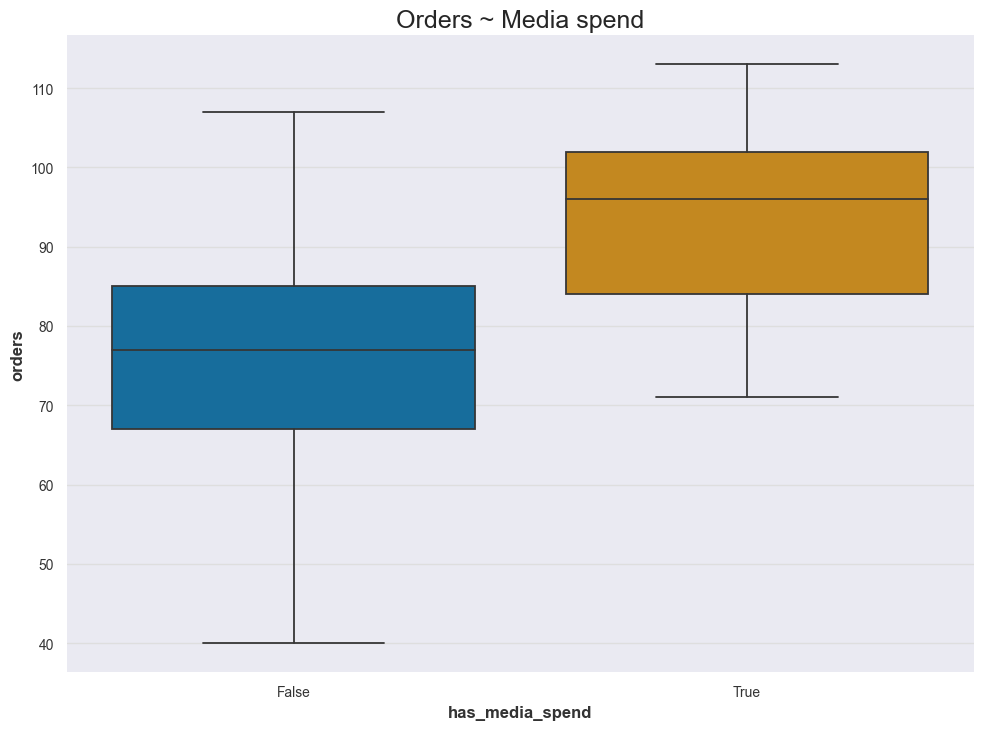

In [29]:
data = data.assign(has_media_spend = data.media_spend>0)
sns.boxplot(x='has_media_spend', y='orders', data=data, palette='colorblind');
plt.title('Orders ~ Media spend', fontsize=18);

### Comments
Marketing spend is correlated with more orders. Intuitively, this makes sense, as this is the intended effect of spending on marketing. 

Below, we investigate if the effect of marketing spend is only on a single day, or on several subsequent days.

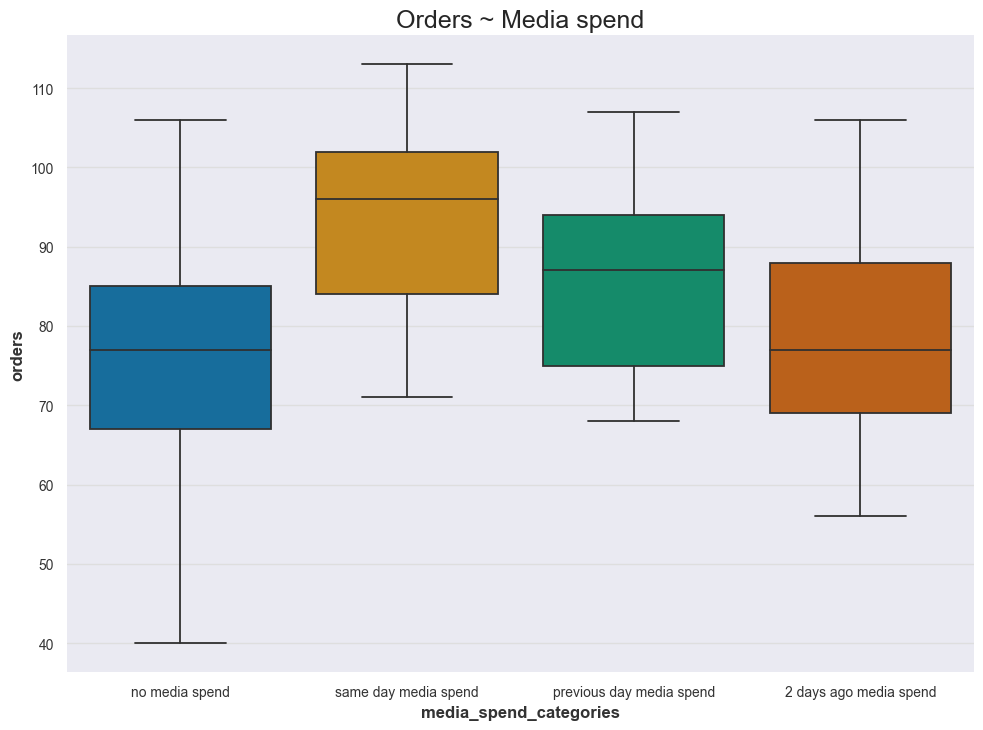

In [30]:
data = data.assign(
    media_spend_categories=np.where(
        data.has_media_spend, 
        'same day media spend', 
        np.where(
            data.has_media_spend.shift(1).fillna(False), 
            'previous day media spend', 
            np.where(
                data.has_media_spend.shift(2).fillna(False), 
                '2 days ago media spend', 
                'no media spend'
            )
        )
    )
)
sns.boxplot(x='media_spend_categories', y='orders', data=data, palette='colorblind');
plt.title('Orders ~ Media spend', fontsize=18);

### Comments
Interestingly, the effect of marketing spend is felt not only on the day it takes place, but also on 1 subsequent day. We create a lagged media_spend feature to capture this. 

In [31]:
data = data.assign(
    media_spend_categories= np.where(
        data.has_media_spend, 
        'same day media spend', 
        np.where(
            data.has_media_spend.shift(1).fillna(False), 
            'previous day media spend',
            'no media spend'
        )
    ),
    prev_day_media_spend= data.media_spend.shift(1).fillna(0)
)

Now that we have thouroughly explored the dataset, we move on to backtesting several prediction models.

# 3. Backtesting the models

## Data

In [71]:
data = pd.read_csv('../data/data.csv')
data = (
    data
    .assign(
        date=pd.to_datetime(data.date).dt.date, 
        datetime=pd.to_datetime(data.date)
    )
    .rename(
        mapper={'orders':'raw_orders'}, 
        axis=1
    )
)
data.set_index('datetime', inplace=True)

## Parameters

#### Prediction datetimes
We start forecasting orders once we have 3 weeks of history.

In [72]:
PREDICTION_DATETIME = datetime(2020, 7, 11)

In [73]:
base = datetime(2020, 5, 25)
PREDICTION_DATETIME_LIST = [base + timedelta(weeks=weeks) for weeks in range(110)]
print(f"We make {len(PREDICTION_DATETIME_LIST)} predictions.")
print(f"First prediction date: {str(min(PREDICTION_DATETIME_LIST).date())}\nLast prediction date: {str(max(PREDICTION_DATETIME_LIST).date())}")

We make 110 predictions.
First prediction date: 2020-05-25
Last prediction date: 2022-06-27


#### Forecast horizon
We forecast for the upcoming 2 weeks, so 14 days ahead.

In [74]:
HORIZON = 14

In [75]:
PLOT_HISTORY = 4*7

### Dictionary used to store backtesting results

In [76]:
forecasting_results = dict()

## Util: time series splitting
A simple util function that splits a time series into a training and test set. Used when backtesting time series forecasting models.

In [77]:
def split_time_series(df: pd.DataFrame, prediction_datetime: date, horizon=HORIZON) -> Tuple[pd.DataFrame]:
    if prediction_datetime not in df.index:
        raise ValueError('Prediction date is outside of time series range')
    return (
        df.loc[:prediction_datetime-timedelta(days=1)], 
        df.loc[prediction_datetime: prediction_datetime+timedelta(days=horizon-1)]
    )

## Util: Plot forecast vs actuals

In [78]:
def plot_forecast_vs_actuals(train_df: pd.DataFrame, test_df:pd.DataFrame, model_name:str) -> None:
    # create dataframes
    actuals = pd.DataFrame(
        columns = ['date', 'orders'], 
        data=pd.concat(
            [
                train_df[['date', 'orders']], 
                test_df[['date', 'orders']]
            ], 
            ignore_index=True)
    )
    plot_df = (
        actuals
        .merge(
            test_df[['date', 'forecast_orders', 'lower_bound', 'upper_bound']], 
            on='date', 
            how='left'
        )
    )

    # create plot
    ax = plot_df.set_index('date')[['orders', 'forecast_orders']].rename(mapper={'orders': 'observed', 'forecast_orders':'forecast'}, axis=1).plot(color=['blue', 'orange'])
    plt.ylabel('orders');
    plt.title(f'14 day ahead forecast vs actuals - {model_name}', fontsize=18);

    # plot prediction interval
    ax.fill_between(plot_df.date, plot_df.lower_bound, plot_df.upper_bound, color='orange', alpha=.1);

## Util: detect and impute outliers
We impute outliers with the order count from the previous week. This is adapted to a production setting, in which we will not have access to future values. Imputing outliers with a forecasted value generalises to all outliers: it works if the outlier was observed in the past, as well as if the outlier was the last observed value. 

We could also use different imputation method, and aggregate them, since the approach implemented below does not factor in seasonality and other factors influencing demand (media spend, temperature):
- backcasting, if we have access to subsequent order counts at training time
- forecasting, using more complex methods implemented below
- interpolation, if we have access to previous and subsequent order counts at training time

In [79]:
def remove_outliers_production(df: pd.DataFrame):
    """
    When an outlier is detected, we use the order count from the previous week.
    """
    df = df.assign(orders=_mean_filter(df.raw_orders))
    df = df.assign(orders=np.where(df.orders.isnull(), df.orders.shift(7), df.orders))
    return df

In [80]:
data = remove_outliers_production(data)
data = data.assign(temperature_range= _temperature_filter(ts=data.temperature))
data = data.assign(has_media_spend = data.media_spend>0)
data = data.assign(
    media_spend_categories= np.where(
        data.has_media_spend, 
        'same day media spend', 
        np.where(
            data.has_media_spend.shift(1).fillna(False), 
            'previous day media spend',
            'no media spend'
        )
    ),
    prev_day_media_spend= data.media_spend.shift(1).fillna(0)
)

#### Snapshot: samples affected by imputation

In [81]:
data.loc[data.orders != data.raw_orders]

,date,raw_orders,temperature,media_spend,orders,temperature_range,has_media_spend,media_spend_categories,prev_day_media_spend
datetime,,,,,,,,,
2020-06-03,2020-06-03,2952,9.493584,0.0,80.0,normal,False,no media spend,0.0
2021-01-14,2021-01-14,2816,-4.468595,0.0,54.0,normal,False,no media spend,0.0
2021-03-22,2021-03-22,4080,20.155265,0.0,82.0,normal,False,no media spend,0.0


## 3.1 Baseline model: Naive Seasonal
We use a naive seasonal model as a baseline for this task. This model always repeats the last 7 values of the training set.

### Snapshot: single prediction

In [82]:
train_df, test_df = split_time_series(df=data, prediction_datetime=PREDICTION_DATETIME)

In [83]:
train = TimeSeries.from_series(train_df.orders)
series = TimeSeries.from_series(pd.concat([train_df.orders, test_df.raw_orders]))

### Util: helper function to compute prediction interval of seasonal naive model

In [84]:
def _compute_resid_std(target: pd.Series, period=7):
    """Computes the standard deviation of the residuals"""
    past_predictions = target.shift(period)
    resid = past_predictions[period :] - target[period :]
    return np.sqrt(sum(resid.values ** 2) / len(resid))

def compute_prediction_intervals(
    historical_ts: pd.Series,
    forecast_dates: List[datetime],
    prediction_ts: pd.Series,
    period=7
):
    """Computes the prediction interval of the forecast"""
    resid_std = _compute_resid_std(historical_ts)
    multiplier = norm.interval(0.95)[1]
    steps = np.arange(1, len(forecast_dates) + 1)
    lower_bound = prediction_ts - multiplier * resid_std * np.sqrt(
        1 + (steps - 1) // period
    )
    upper_bound = prediction_ts + multiplier * resid_std * np.sqrt(
        1 + (steps - 1) // period
    )
    return lower_bound, upper_bound

In [85]:
naive_model = NaiveSeasonal(K=7)
naive_model.fit(train)
naive_forecast = naive_model.predict(HORIZON)
test_df= test_df.assign(
    forecast_orders= np.round(naive_forecast.values())
)
naive_lower_bound, naive_upper_bound = compute_prediction_intervals(
    historical_ts=train_df.orders, 
    forecast_dates=test_df.index, 
    prediction_ts=test_df.forecast_orders
)
test_df= test_df.assign(
    lower_bound=naive_lower_bound, 
    upper_bound=naive_upper_bound
)

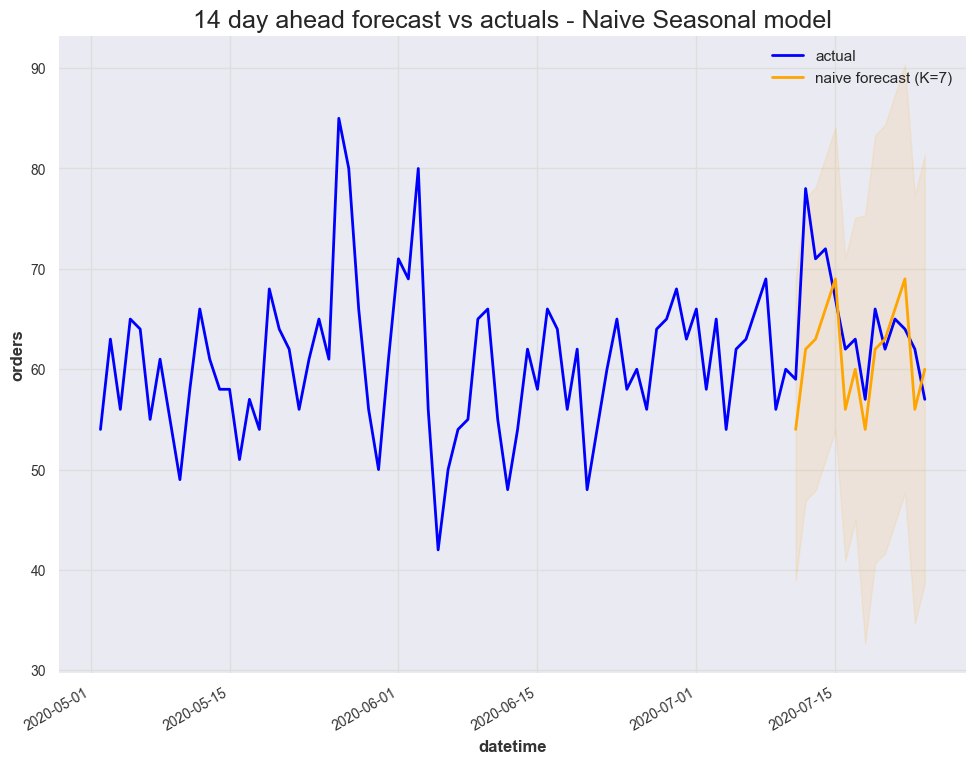

In [86]:
ax = series.plot(label="actual", color='blue')
naive_forecast.plot(label="naive forecast (K=7)", color='orange');
ax.fill_between(test_df.date, test_df.lower_bound, test_df.upper_bound, color='orange', alpha=.1);
plt.title('14 day ahead forecast vs actuals - Naive Seasonal model', fontsize=18);
plt.ylabel('orders');

### Overall: pipeline on all prediction dates
We run the baseline model 110 times, on all mondays in `PREDICTION_DATETIME_LIST`.

In [87]:
naive_forecasts = []
for dt in PREDICTION_DATETIME_LIST:
    # create train test datasets
    train_df, test_df= split_time_series(df=data, prediction_datetime=dt)

    # create TimeSeries objects
    train = TimeSeries.from_series(train_df.orders)
    series = TimeSeries.from_series(pd.concat([train_df.orders, test_df.orders]))

    # Fit Naive Seasonal model
    naive_model = NaiveSeasonal(K=7)
    naive_model.fit(train)

    # Store forecasts
    naive_forecast = naive_model.predict(len(test_df.index))
    test_df= test_df.assign(
        forecast_orders=np.round(naive_forecast.values())
    )
    naive_lower_bound, naive_upper_bound = compute_prediction_intervals(
        historical_ts=train_df.orders, 
        forecast_dates=test_df.index, 
        prediction_ts=test_df.forecast_orders
    )
    test_df= test_df.assign(
        lower_bound= naive_lower_bound, 
        upper_bound=naive_upper_bound, 
        residuals=test_df.forecast_orders - test_df.orders, 
        forecast_datetime=dt
    )
    naive_forecasts.append(test_df)

### Model evaluation: overall forecasting accuracy
We use 4 separate accuracy metrics, each assessing out of sample model performance with a different angle:
- Mean Absolute Error: a measure of the error, unit is number of orders
- Root Mean Squared Error: penalises bigger misses more, unit is number of orders
- Bias: a measure of bias (under/over forecasting). We want it to be as close to 0 as possible. Unit is number of orders
- Coverage: % of observed values within the prediction interval.

In [88]:
naive_forecasts_df = pd.concat(naive_forecasts, ignore_index=True)
naive_forecasts_df = naive_forecasts_df.assign(
    is_covered= (naive_forecasts_df.orders<=naive_forecasts_df.upper_bound) & (naive_forecasts_df.orders>=naive_forecasts_df.lower_bound)
)
forecasting_results['NaiveSeasonal'] = {
    'MAE': np.round(
        mean_absolute_error(
            naive_forecasts_df.orders, 
            naive_forecasts_df.forecast_orders
        ), 
        5
    ),
    'RMSE': np.round(
        mean_squared_error(
            naive_forecasts_df.orders, 
            naive_forecasts_df.forecast_orders, 
            squared=False
        ), 
        5
    ),
    'bias': np.round(naive_forecasts_df.residuals.mean(), 5),
    'coverage': np.round(naive_forecasts_df.is_covered.sum()/naive_forecasts_df.shape[0], 3)
}

In [89]:
forecasting_results

{'NaiveSeasonal': {'MAE': 6.90308,
  'RMSE': 9.0149,
  'bias': -0.29666,
  'coverage': 0.951}}

### Model evaluation: analysis of the residuals
For every model, we analyse the residuals, as they reveal potential improvements we can make to the forecasting model.

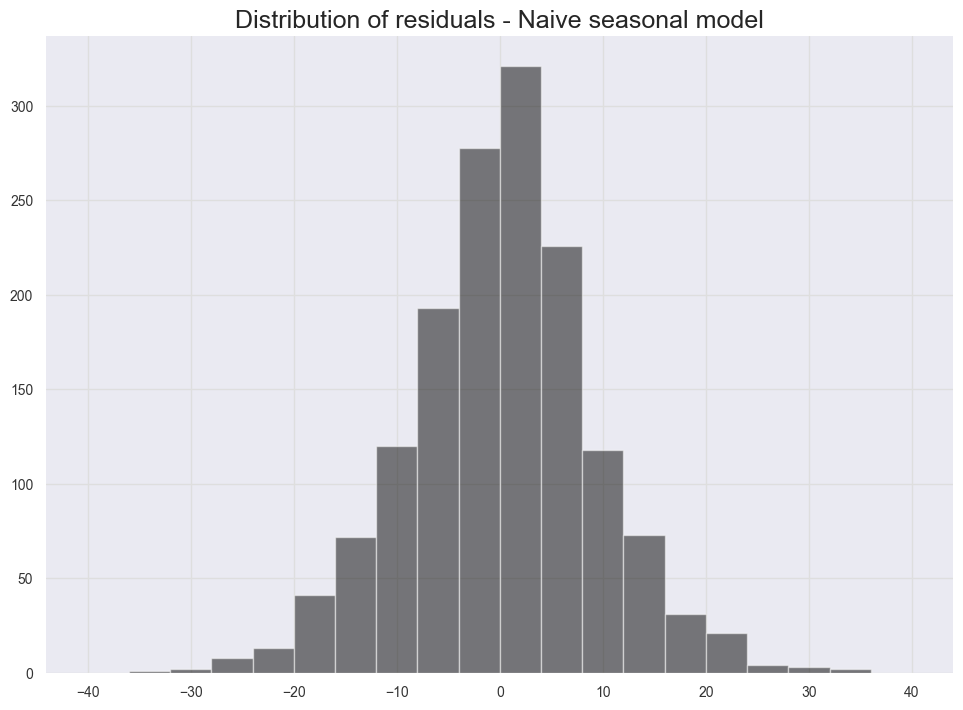

In [90]:
naive_forecasts_df.residuals.hist(bins=np.arange(-40, 44, 4),color='black', alpha=0.5);
plt.title('Distribution of residuals - Naive seasonal model', fontsize=18);

#### Comments
The Naive seasonal model seems to be slightly biased towards under-forecasting. This could be because seasonal naive models do not factor in any trend. We move on to an exponential smoothing model, which factors in an additive, damped trend.

## 3.2 Exponential smoothing model

### Snapshot: single prediction

In [91]:
train_df, test_df= split_time_series(df=data, prediction_datetime=PREDICTION_DATETIME)

In [92]:
ets_model = ETSModel(
    endog=train_df.orders, 
    trend='add', 
    seasonal='add', 
    damped_trend=True, 
    seasonal_periods=7, 
    freq='D'
)
ets_result = ets_model.fit(disp=False)

In [93]:
ci = ets_result.get_prediction(start=test_df.index[0], end=test_df.index[-1])

In [94]:
test_df = test_df.assign(
    forecast_orders=np.round(ci.predicted_mean), 
    lower_bound= ci.pred_int(alpha = .05)['lower PI (alpha=0.050000)'], 
    upper_bound= ci.pred_int(alpha = .05)['upper PI (alpha=0.050000)']
)

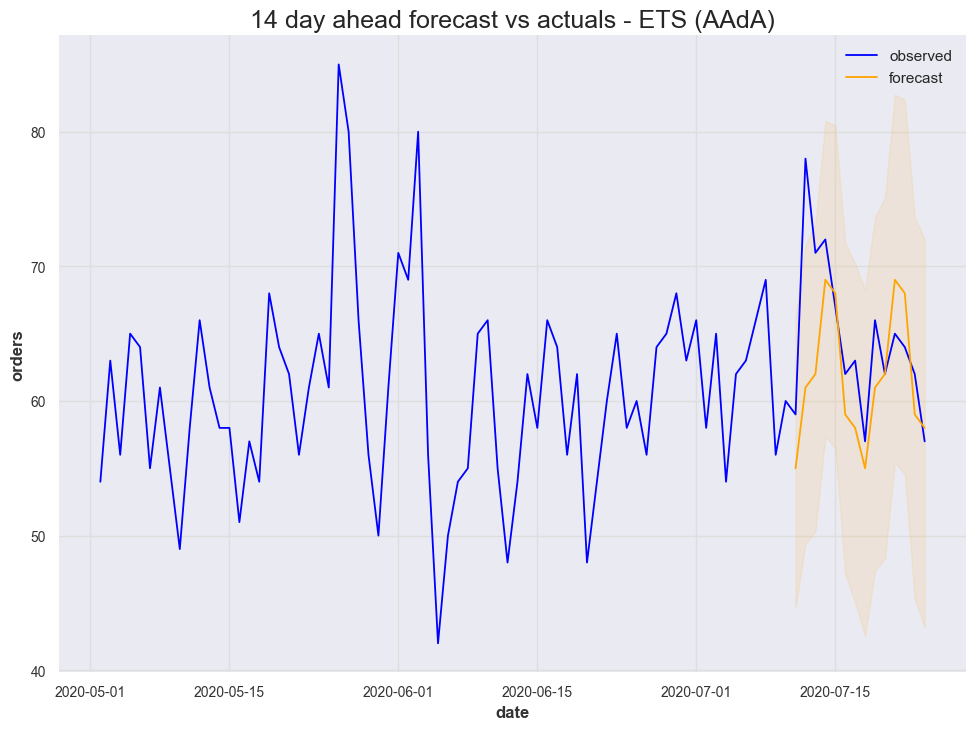

In [95]:
plot_forecast_vs_actuals(train_df, test_df, model_name=f"ETS ({ets_model.short_name})")

### Overall: pipeline on all prediction dates

In [96]:
ets_forecasts = []
for dt in PREDICTION_DATETIME_LIST:
    # Create train, test datasets
    train_df, test_df= split_time_series(
        df=data, 
        prediction_datetime=dt
    )

    # Fit Exponential smoothing model
    ets_model = ETSModel(
        endog=train_df.orders, 
        trend='add', 
        seasonal='add', 
        damped_trend=True, 
        seasonal_periods=7, 
        freq='D'
    )
    ets_result = ets_model.fit(disp=False)

    # Store forecasts
    ci = ets_result.get_prediction(start=test_df.index[0], end=test_df.index[-1])
    test_df = test_df.assign(
        forecast_orders=np.round(ci.predicted_mean), 
        lower_bound= ci.pred_int(alpha = .05)['lower PI (alpha=0.050000)'], 
        upper_bound= ci.pred_int(alpha = .05)['upper PI (alpha=0.050000)']
    )
    test_df= test_df.assign(
        residuals=test_df.forecast_orders - test_df.orders, 
        forecast_datetime=dt
    )
    ets_forecasts.append(test_df)

### Model evaluation: overall forecasting accuracy

In [97]:
ets_forecasts_df = pd.concat(ets_forecasts, ignore_index=True)
ets_forecasts_df = ets_forecasts_df.assign(
    is_covered= (ets_forecasts_df.orders<=ets_forecasts_df.upper_bound) & (ets_forecasts_df.orders>=ets_forecasts_df.lower_bound)
)
forecasting_results[f'ETS ({ets_model.short_name})'] = {
    'MAE': np.round(
        mean_absolute_error(
            ets_forecasts_df.orders, 
            ets_forecasts_df.forecast_orders
        ), 
        5
    ),
    'RMSE': np.round(
        mean_squared_error(
            ets_forecasts_df.orders, 
            ets_forecasts_df.forecast_orders, 
            squared=False
        ), 
        5
    ),
    'bias': np.round(ets_forecasts_df.residuals.mean(), 5),
    'coverage': np.round(ets_forecasts_df.is_covered.sum()/ets_forecasts_df.shape[0], 3)
}

In [98]:
forecasting_results

{'NaiveSeasonal': {'MAE': 6.90308,
  'RMSE': 9.0149,
  'bias': -0.29666,
  'coverage': 0.951},
 'ETS (AAdA)': {'MAE': 5.87164,
  'RMSE': 7.58769,
  'bias': -0.06811,
  'coverage': 0.921}}

### Model evaluation: analysis of the residuals

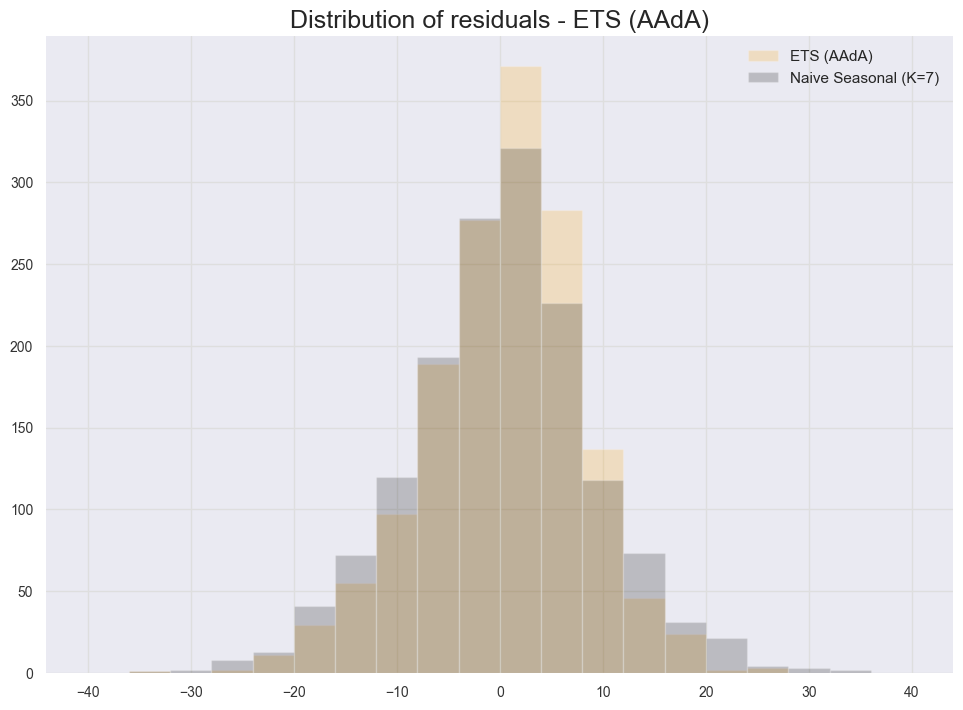

In [99]:
ets_forecasts_df.residuals.hist(bins=np.arange(-40, 44, 4),color='orange', alpha=0.2, label=f'ETS ({ets_model.short_name})');
naive_forecasts_df.residuals.hist(bins=np.arange(-40, 44, 4),color='black', alpha=0.2, label='Naive Seasonal (K=7)')
plt.legend(loc="upper right")
plt.title(f'Distribution of residuals - ETS ({ets_model.short_name})', fontsize=18);

#### Comments
The exponential smoothing is a 16% improvement on the baseline model in terms of RMSE. It is less biased than the Naive seasonal approach, although still slightly biased towards under-forecasting.

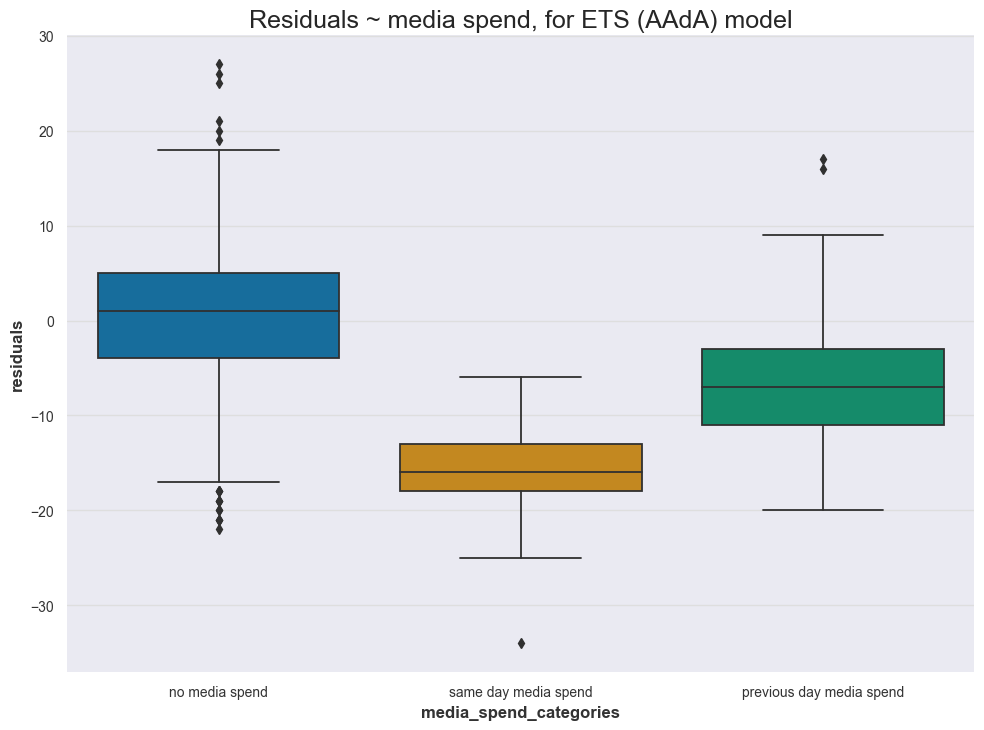

In [100]:
sns.boxplot(x='media_spend_categories', y='residuals', data=ets_forecasts_df, palette='colorblind');
plt.title(f'Residuals ~ media spend, for ETS ({ets_model.short_name}) model', fontsize=18);

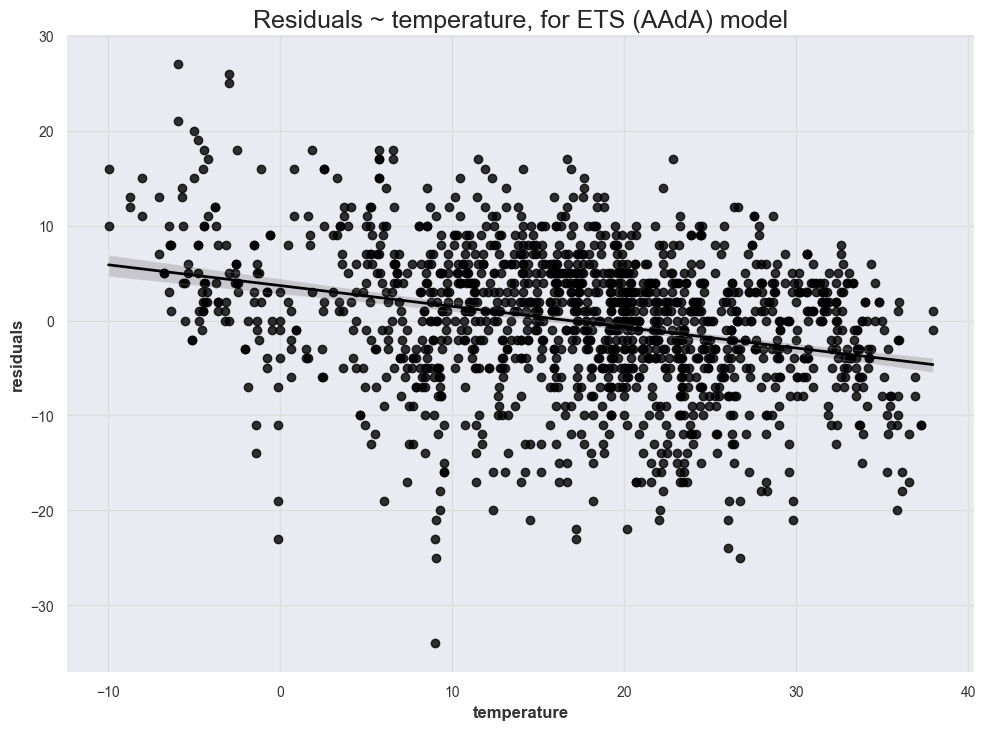

In [101]:
sns.regplot(x='temperature', y='residuals', data=ets_forecasts_df);
plt.title(f'Residuals ~ temperature, for ETS ({ets_model.short_name}) model', fontsize=18);

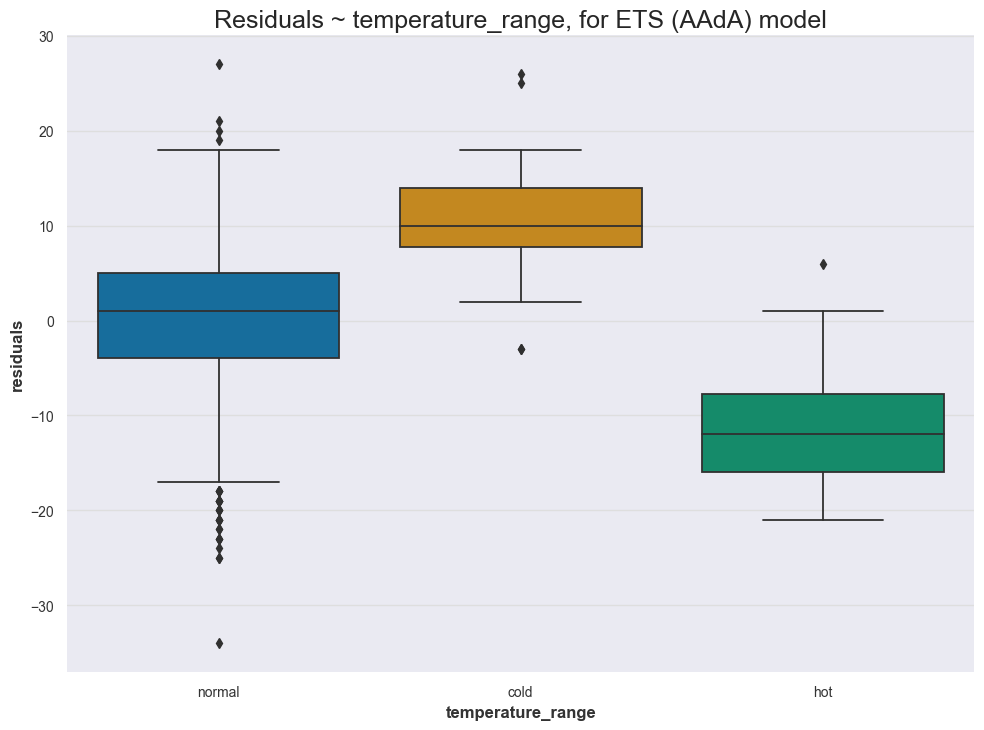

In [102]:
sns.boxplot(x='temperature_range', y='residuals', data=ets_forecasts_df, palette='colorblind');
plt.title(f'Residuals ~ temperature_range, for ETS ({ets_model.short_name}) model', fontsize=18);

#### Comments
There is a lot of signal left in the residuals. 
- Samples with media spend on the same or previous day tend to have higher than expected orders, which makes sense from a business point of view.
- Samples with low temoperatures (sub-zero) have lower than expected orders, while those with high temperatures (over 35 degrees) have higher than expected orders.
- Samples with temperatures that are above the expected range for that season have higher than expected orders, while those below the range have lower than expected orders.

Below, we use a prophet model that takes into account exogenous features (media spend, temperature) to improve forecasting accuracy

## 3.3 Prophet, with media_spend and temperature as exogenous variables
Since Prophet models need to have access to the temperature values for the dates we want to predict, we propose to forecast temperatures and use the forecasted values as future covariates.

### Snapshot: single prediction

In [103]:
train_df, test_df= split_time_series(df=data, prediction_datetime=PREDICTION_DATETIME)
train_df = train_df.assign(temperature= train_df.temperature.fillna(method='ffill'))

In [104]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.add_regressor('media_spend')
prophet_model.add_regressor('prev_day_media_spend')
prophet_model.add_regressor('temperature')
prophet_model.fit(
    train_df[['date', 'orders', 'media_spend', 'prev_day_media_spend', 'temperature']].rename(mapper={'date':'ds', 'orders':'y'}, axis=1)
)

12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
test_df = test_df.assign(temperature=train_df.iloc[-7:].temperature.median())

### Comments
**Temperature values are only available for current and past days, not future days**. That's why we use it to explain the observed variance in the training set, but **we set a constant temperature in the future dataset** (the median of the last week of the training set).

In [111]:
# Create dataset with future values of covariates
features_df = (
    pd.concat(
        [
            train_df[['media_spend', 'prev_day_media_spend', 'temperature']], 
            test_df[['media_spend', 'prev_day_media_spend', 'temperature']]
        ], 
        axis=0
    )
    .reset_index()
    .rename(mapper={'datetime': 'ds'}, axis=1)
)
future = (
    prophet_model
    .make_future_dataframe(periods=14)
    .merge(features_df, on='ds', how='left')
)

In [112]:
prophet_forecast = (
    prophet_model
    .predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    .rename(
        mapper={
            'ds': 'date', 
            'yhat':'forecast_orders', 
            'yhat_lower':'lower_bound', 
            'yhat_upper': 'upper_bound'
        }, 
        axis=1
    )
)
prophet_forecast = prophet_forecast.assign(
    date= pd.to_datetime(prophet_forecast.date).dt.date
)
test_df = test_df.merge(
    prophet_forecast, 
    on=['date'], 
    how='left'
)
test_df = test_df.assign(
    forecast_orders= test_df.forecast_orders.round()
)

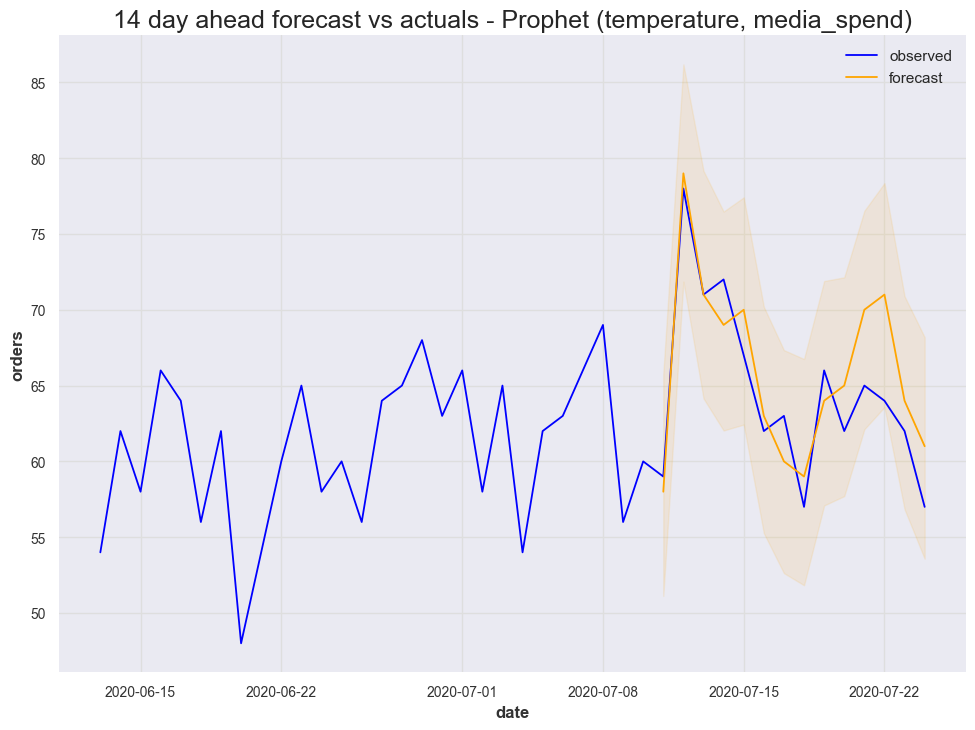

In [113]:
plot_forecast_vs_actuals(
    train_df=train_df.loc[PREDICTION_DATETIME-timedelta(days=PLOT_HISTORY):], 
    test_df=test_df, 
    model_name='Prophet (temperature, media_spend)'
)

#### Snapshot: Inspecting the components of the Prophet model

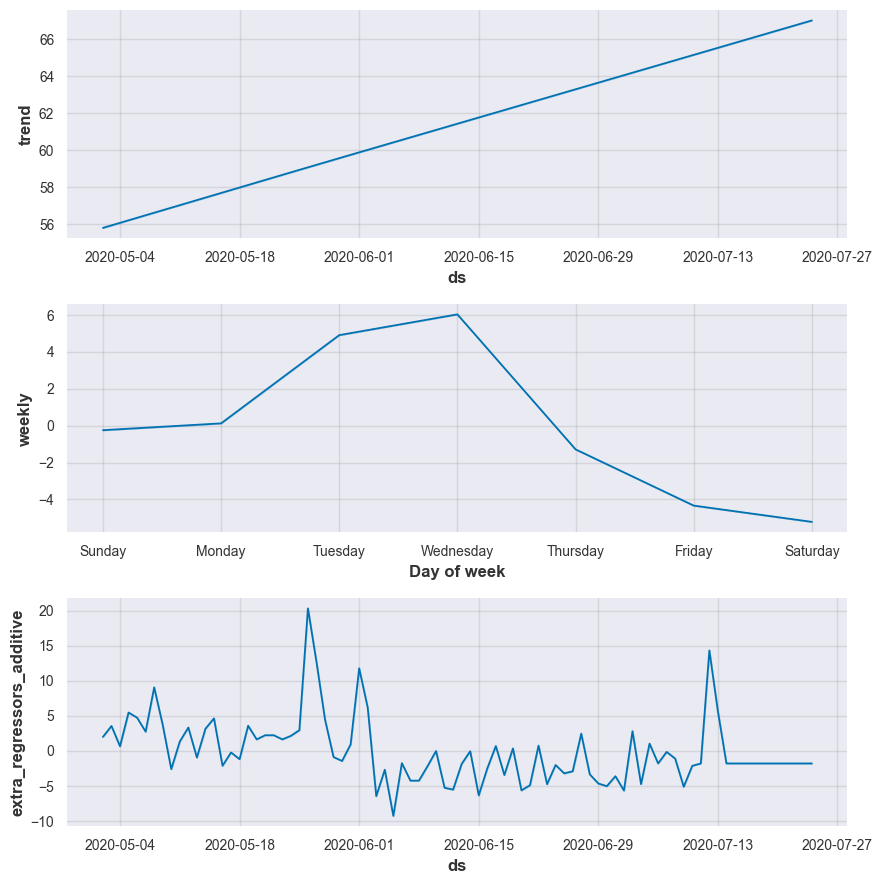

In [114]:
fig = prophet_model.plot_components(prophet_model.predict(future))

In [115]:
regressor_coefficients(prophet_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,media_spend,additive,0.421722,1.076269,1.076269,1.076269
1,prev_day_media_spend,additive,0.421722,0.495974,0.495974,0.495974
2,temperature,additive,15.497412,0.962545,0.962545,0.962545


#### Comments
Prophet correctly picks up on the weekly seasonality, with peaks on Tuesday and Wednesday, and troughs on Friday and Saturday. This is what we identified in the exploration part of this notebook.

### Overall: pipeline on all prediction dates

In [116]:
prophet_ms_temp_forecasts = []
for dt in PREDICTION_DATETIME_LIST:
    # create train, test datasets
    train_df, test_df= split_time_series(df=data, prediction_datetime=dt)

    # impute missing temperature values
    train_df = train_df.assign(
        temperature= train_df.temperature.fillna(method='ffill')
    )

    # Fit Prophet model
    prophet_ms_temp_model = Prophet(interval_width=0.95)
    prophet_ms_temp_model.add_regressor('media_spend')
    prophet_ms_temp_model.add_regressor('prev_day_media_spend')
    prophet_ms_temp_model.add_regressor('temperature')
    prophet_ms_temp_model.fit(
        train_df[['date', 'orders', 'media_spend', 'prev_day_media_spend', 'temperature']].rename(mapper={'date':'ds', 'orders':'y'}, axis=1)
    )

    # Creating temperature feature in future dataframe
    test_df = test_df.assign(
        observed_temperature= test_df.temperature, 
        temperature=train_df.iloc[-7:].temperature.median()
    )

    # Create future dataframe
    features_df = (
        pd.concat(
            [
                train_df[['media_spend', 'prev_day_media_spend', 'temperature']], 
                test_df[['media_spend', 'prev_day_media_spend', 'temperature']]
            ]
        )
        .reset_index()
        .rename(mapper={'datetime': 'ds'}, axis=1)
    )
    future = (
        prophet_ms_temp_model
        .make_future_dataframe(periods=len(test_df.index))
        .merge(features_df, on='ds', how='left')
    )

    # Store forecasts
    prophet_ms_temp_forecast = (
        prophet_ms_temp_model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        .rename(
            mapper={
                'ds': 'date', 
                'yhat':'forecast_orders', 
                'yhat_lower':'lower_bound', 
                'yhat_upper': 'upper_bound'
            }, 
            axis=1
        )
    )
    prophet_ms_temp_forecast = prophet_ms_temp_forecast.assign(
        date= pd.to_datetime(prophet_ms_temp_forecast.date).dt.date
    )
    test_df = test_df.merge(
        prophet_ms_temp_forecast, 
        on=['date'], 
        how='left'
    )
    test_df = test_df.assign(
        forecast_orders=test_df.forecast_orders.round()
    )
    test_df= test_df.assign(
        residuals=test_df.forecast_orders - test_df.orders, 
        forecast_datetime=dt
    )
    prophet_ms_temp_forecasts.append(test_df)

12:17:14 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:17 - cmdstanpy - INFO - Chain [1] start processing
12:17:17 - cmdstanpy - INFO - Chain [1]

### Model evaluation: overall forecasting accuracy

In [117]:
prophet_ms_temp_forecasts_df = pd.concat(prophet_ms_temp_forecasts, ignore_index=True)
prophet_ms_temp_forecasts_df = prophet_ms_temp_forecasts_df.assign(
    is_covered=(prophet_ms_temp_forecasts_df.orders<=prophet_ms_temp_forecasts_df.upper_bound) & (prophet_ms_temp_forecasts_df.orders>=prophet_ms_temp_forecasts_df.lower_bound)
)
forecasting_results['Prophet'] = {
    'MAE': np.round(
        mean_absolute_error(
            prophet_ms_temp_forecasts_df.orders, 
            prophet_ms_temp_forecasts_df.forecast_orders
        ), 
        5
    ),
    'RMSE': np.round(
        mean_squared_error(
            prophet_ms_temp_forecasts_df.orders, 
            prophet_ms_temp_forecasts_df.forecast_orders, 
            squared=False
        ), 
        5
    ),
    'bias': np.round(prophet_ms_temp_forecasts_df.residuals.mean(), 5),
    'coverage': np.round(prophet_ms_temp_forecasts_df.is_covered.sum()/prophet_ms_temp_forecasts_df.shape[0], 3)
}

In [118]:
forecasting_results

{'NaiveSeasonal': {'MAE': 6.90308,
  'RMSE': 9.0149,
  'bias': -0.29666,
  'coverage': 0.951},
 'ETS (AAdA)': {'MAE': 5.87164,
  'RMSE': 7.58769,
  'bias': -0.06811,
  'coverage': 0.921},
 'Prophet': {'MAE': 5.10216,
  'RMSE': 6.67277,
  'bias': 0.49967,
  'coverage': 0.697}}

### Model evaluation: analysis of the residuals

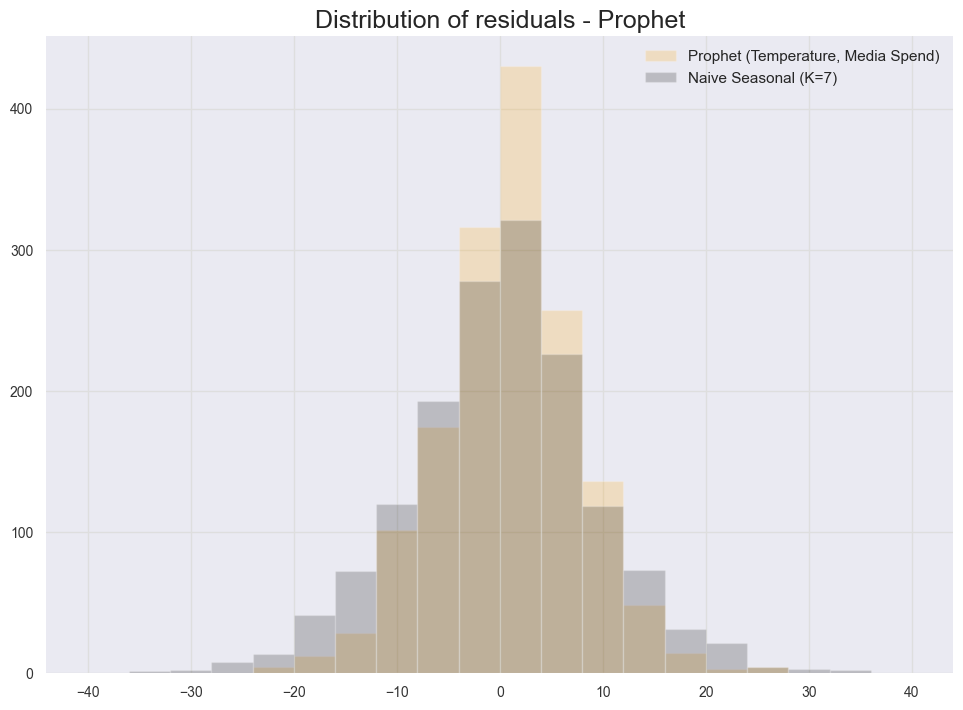

In [120]:
prophet_ms_temp_forecasts_df.residuals.hist(bins=np.arange(-40, 44, 4),color='orange', alpha=0.2, label='Prophet (Temperature, Media Spend)');
naive_forecasts_df.residuals.hist(bins=np.arange(-40, 44, 4),color='black', alpha=0.2, label='Naive Seasonal (K=7)')
plt.title(f'Distribution of residuals - Prophet', fontsize=18);
plt.legend(loc="upper right");

#### Comments
The Prophet model with exogenous features is a 26% improvement on the baseline model in terms of RMSE. It is more biased than the Exponential smoothing, although this time towards over-forecasting.

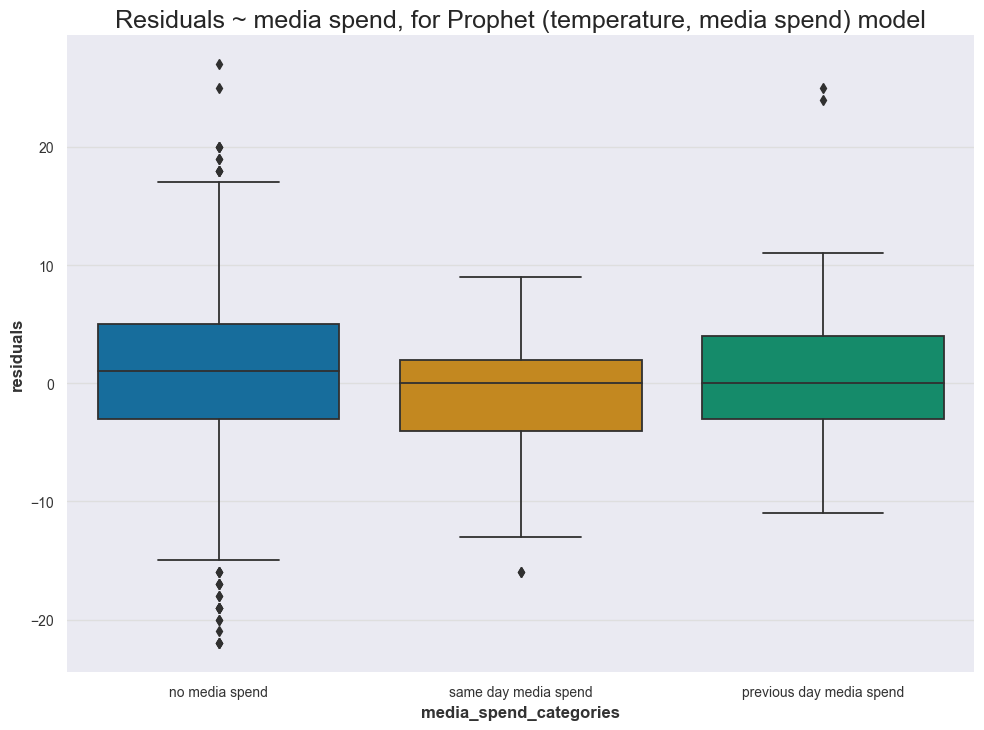

In [121]:
sns.boxplot(x='media_spend_categories', y='residuals', data=prophet_ms_temp_forecasts_df, palette='colorblind')
plt.title(f'Residuals ~ media spend, for Prophet (temperature, media spend) model', fontsize=18);

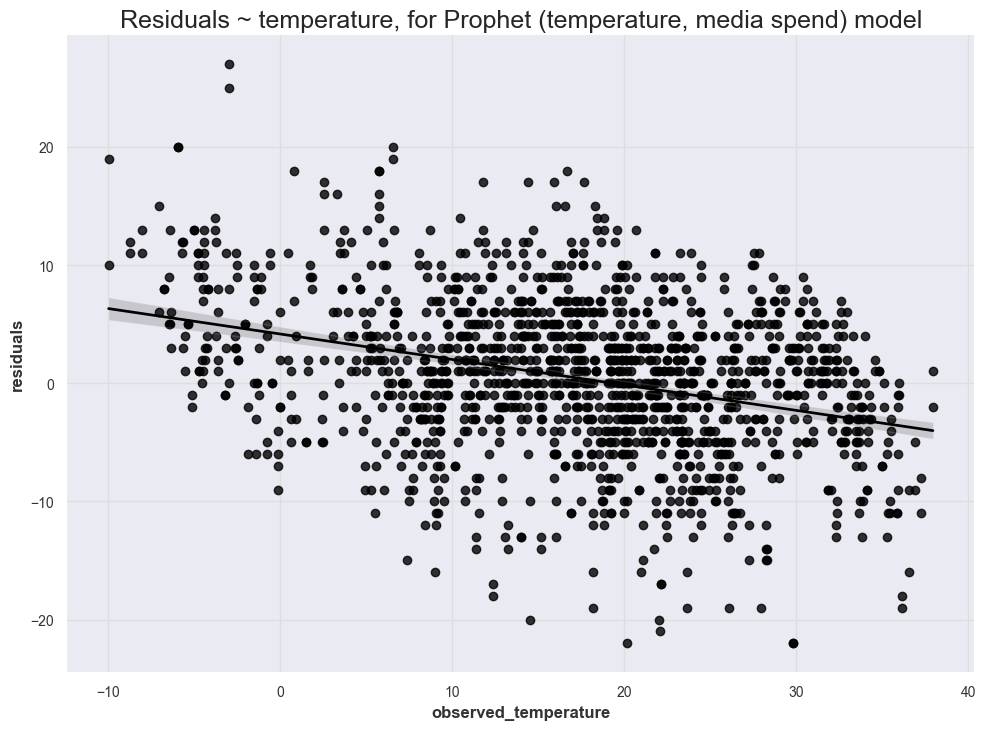

In [122]:
sns.regplot(x='observed_temperature', y='residuals', data=prophet_ms_temp_forecasts_df);
plt.title(f'Residuals ~ temperature, for Prophet (temperature, media spend) model', fontsize=18);

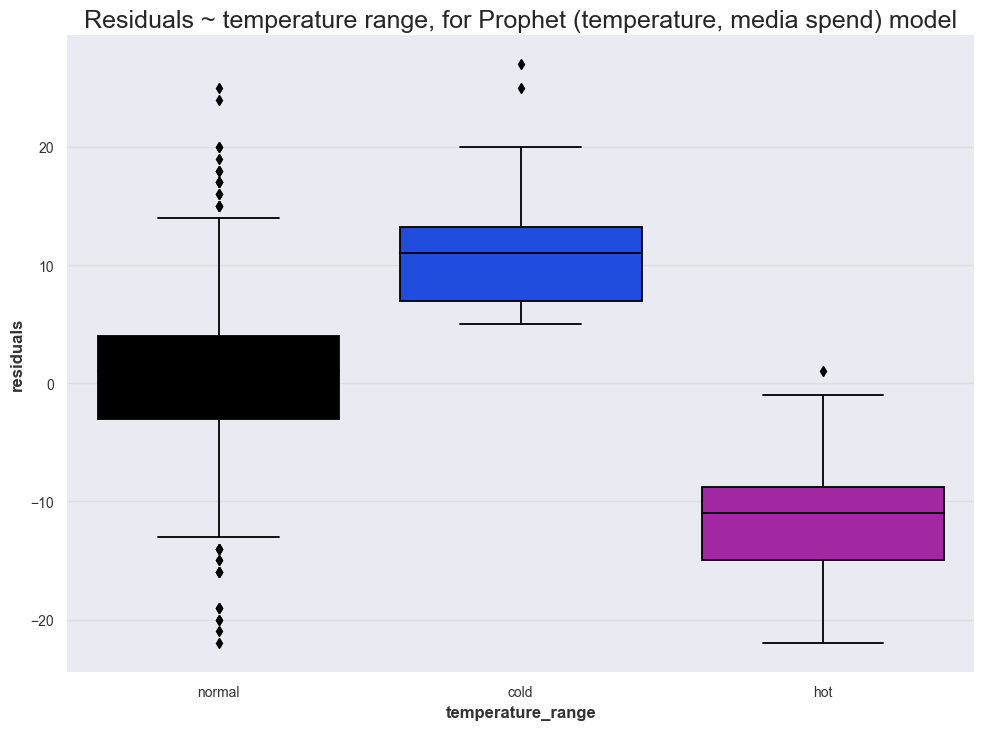

In [123]:
sns.boxplot(x='temperature_range', y='residuals', data=prophet_ms_temp_forecasts_df);
plt.title(f'Residuals ~ temperature range, for Prophet (temperature, media spend) model', fontsize=18);

#### Comments
The prophet model is a clear improvement on the baseline approach, yielding a 26% improvement in RMSE.

Using the 2 media spend features (same day and lagged) seems like a judicious approach. The distributions of residuals for samples with or without media spend are centered around 0.

However, there is still signal left in the residuals. Samples with temperatures that are above the expected range for that season have higher than expected orders, while those below the range have lower than expected orders. This is expected because **we are not using the temperature of the dates we are trying to forecast**, instead using the median of the last 7 days before the forecast starts. 

A low-hanging fruit to improve this model would be to use weather forecast data, to factor in the effect of temperature on orders.

## Ensemble: Naive Seasonal, Exponential smoothing, Prophet (media spend and temperature)

In [124]:
cols = [
    'date', 
    'forecast_datetime', 
    'forecast_orders', 
    'lower_bound', 
    'upper_bound'
]
ensemble_df = (
    ets_forecasts_df[cols+['orders']]
    .merge(
        prophet_ms_temp_forecasts_df[cols], 
        on=['date', 'forecast_datetime'], 
        how='left', 
        suffixes=['_ets', '_prophet']
    )
)

In [125]:
ensemble_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527 entries, 0 to 1526
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1527 non-null   object        
 1   forecast_datetime        1527 non-null   datetime64[ns]
 2   forecast_orders_ets      1527 non-null   float64       
 3   lower_bound_ets          1527 non-null   float64       
 4   upper_bound_ets          1527 non-null   float64       
 5   orders                   1527 non-null   float64       
 6   forecast_orders_prophet  1527 non-null   float64       
 7   lower_bound_prophet      1527 non-null   float64       
 8   upper_bound_prophet      1527 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 107.5+ KB


In [126]:
ensemble_df = ensemble_df.assign(
    forecast_orders=ensemble_df[['forecast_orders_ets', 'forecast_orders_prophet']].mean(axis=1).round()
)

# For the ensemble model, we set the prediction interval as the widest interval possible from all the models being ensembled
ensemble_df= ensemble_df.assign(
    lower_bound=ensemble_df[['lower_bound_ets', 'lower_bound_prophet']].min(axis=1)
)
ensemble_df = ensemble_df.assign(
    upper_bound=ensemble_df[['upper_bound_ets', 'upper_bound_prophet']].max(axis=1)
)
ensemble_df = ensemble_df.assign(
    residuals= ensemble_df.forecast_orders - ensemble_df.orders
)

In [127]:
ensemble_df = ensemble_df.assign(
    is_covered= (ensemble_df.orders<=ensemble_df.upper_bound) & (ensemble_df.orders>=ensemble_df.lower_bound)
)
forecasting_results['ensemble'] = {
    'MAE': np.round(
        mean_absolute_error(
            ensemble_df.orders, 
            ensemble_df.forecast_orders
        ), 
        5
    ),
    'RMSE': np.round(
        mean_squared_error(
            ensemble_df.orders, 
            ensemble_df.forecast_orders, 
            squared=False
        ), 
        5
    ),
    'bias': np.round(ensemble_df.residuals.mean(), 5),
    'coverage': np.round(ensemble_df.is_covered.sum()/ensemble_df.shape[0], 3)
}

In [128]:
forecasting_results

{'NaiveSeasonal': {'MAE': 6.90308,
  'RMSE': 9.0149,
  'bias': -0.29666,
  'coverage': 0.951},
 'ETS (AAdA)': {'MAE': 5.87164,
  'RMSE': 7.58769,
  'bias': -0.06811,
  'coverage': 0.921},
 'Prophet': {'MAE': 5.10216,
  'RMSE': 6.67277,
  'bias': 0.49967,
  'coverage': 0.697},
 'ensemble': {'MAE': 5.31565,
  'RMSE': 6.84198,
  'bias': 0.21153,
  'coverage': 0.94}}

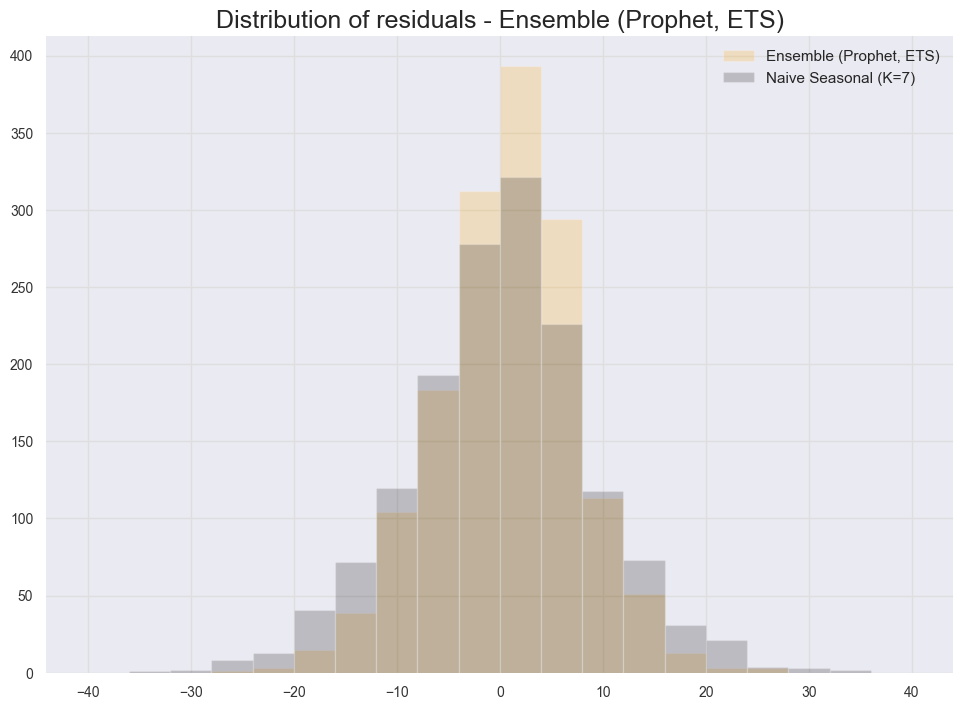

In [129]:
ensemble_df.residuals.hist(bins=np.arange(-40, 44, 4),color='orange', alpha=0.2, label='Ensemble (Prophet, ETS)');
naive_forecasts_df.residuals.hist(bins=np.arange(-40, 44, 4),color='black', alpha=0.2, label='Naive Seasonal (K=7)')
plt.title(f'Distribution of residuals - Ensemble (Prophet, ETS)', fontsize=18);
plt.legend(loc="upper right");

#### Comments
Interestingly, ensemble-ing the Prophet model with the exponential smoothing model does not yield better results. We settle on using a Prophet model, with media spend and temperature as regressors.

## Conclusion

In [130]:
pd.DataFrame(forecasting_results).transpose().sort_values('RMSE')

,MAE,RMSE,bias,coverage
Prophet,5.10216,6.67277,0.49967,0.697
ensemble,5.31565,6.84198,0.21153,0.940
ETS (AAdA),5.87164,7.58769,-0.06811,0.921
NaiveSeasonal,6.90308,9.01490,-0.29666,0.951


## Some ideas for improvements:

- **feature engineering**:
  - factor in "missed" orders: if we forecast too few orders, we have too few couriers available, which leads to delays, or in the worse case closures (by shrinking polygons around restaurants, or closing delivery areas). This leads to missed demand: customers who would have placed an order if there had been enough supply. Thid missed demand should be factored in to predict future demand.
  - missing covariates: I assumed that samples were missing `temperature` values at random. We should verify this.
  - outliers: I made the assumption that outliers were not based on observed values, but coming from telemetry issues, given their magnitude (30x increase on usual levels). We should verify this.
 
- **use hierarchical time series approach**:
  -  forecast orders at a smaller time granularity than daily (hourly or half-hourly): demand patterns vary within the day
  - forecast orders at a smaller/bigger geographic granularity than city level: neighborhoods are more actionable for courier operations, countries for customer service


- **improve time series approach**:
  - self-tuning auto ARIMA
  - exponential smoothing with different trends/seasonality
  - multiple seasonality models (tbats, bats, Fourier terms)
  - Theta method
  - deep learning
 
- **improve ensembling of individual forecasts**:
   - Delphi method with weighted average, weights based on individual model accuracy



- **implement ML-based approach**:
  - lagged orders
  - calendar features (day of week, month of year, public holidays, events)
  - promised delivery time in the app

# 4. Designing and deploying the model: model architecture and how I would deploy it

## Infrastructure overview
For a first iteration, I would design this model to run in batch, at a weekly frequency given the approach suggested above (forecasting 2 weeks ahead every monday). 

Below, you can find a first draft of an architecture of the model training.
I would use an orchestrator like Airflow/Jenkins to deploy this pipeline, and have the time series prediction run in a Kubernetes pod. To have the pipeline scale to more models, I would make it model-agnostic and build a base model class with the same functions for all models (train, predict, ...). For models parameters, I would use a YAML file instead of hardcoding them.

N.B.: I attached a .png file with this notebook in case the image does not load.

![alt text](forecast_dag_graph.png "Title")

## Deployment strategy
To deploy a new model to production, I would use the following process:
1. Test the model offline (similar as this notebook) with backtesting
2. Run the model online, in "shadow mode": the model is running, but it is not being used in the final ensemble
3. Validate model accuracy
4. Include model in final ensemble

## Monitoring strategy
I would create several dashboards to monitor forecasts.

- Stakeholder-facing forecast accuracy dashboard
  
This would be the reference for forecasting accuracy metrics. The dashboard would contain stakeholder-friendly summary accuracy metrics (MAPE, RMSE), as well as plots of forecasts vs actuals.

- Internal forecast accuracy dashboard
  
This dashboard would be used internally by the DS team to assess forecasting models accuracy. It would track metrics like MAE, bias, RMSE, and contain plots of the residuals.

- Internal reliability dashboard

This dashboard would be used internally by the DS team to assess how forecasts evolve relatively to each other, in order to spot outliers, faulty deployments or bugs.